#Time Series Clustering using Python

*Lee Min Hua*

A time series is a sequence of continuous values in time order. Its nature of high dimensionality with vast amount of noise presents difficulties in characterizing them that cannot be easily achieved using classic machine learning and data mining algorithms. In recent years, time series clustering has been widely used in determining and extracting valuable information in various sectors, especially in finance sector. Financial institutions have been using time series data to cluster companies in the stock markets merely based on their similarities in the time series graph shape. This approach, however, was proven to be impractical as stock price data are high dimensional and the changes in the stock price usually occur with shift instead of at the same time which makes the categorization even more challenging. A three-phase time series clustering, 3PTC has been proposed by Aghabozorgi & Teh (2014) which is able to approximately categorize companies by first transforming their time series data into a low dimensional space and cluster them based on the similarity of their stock markets’ shape.

In this python notebook, the first step of the model, which is the pre-clustering stage is implemented, which aims to reduce the search space by clustering the stock data in a low-resolution mode.

### Data Preprocessing


The dataset used for the implementation is the historical stock prices of last 5 years for all companies currently found on the S&P 500 index. The dataset can be found in the below link:<br>
https://www.kaggle.com/camnugent/sandp500

The dataset contains the following attributes:<br>

Date - in format yy-mm-dd <br>
Open - price of the stock at market open in USD<br>
High - Highest price reached in the day in USD<br>
Low Close - Lowest price reached in the day in USD<br>
Volume - Number of shares traded<br>
Name - the stock's ticker name<br>

Before the data is ready to be used for the analysis, some preprocessing steps including removal of missing values, transformation and feature extraction need to be carried out in order to facilitate the implementation and maximize the credibility of the study result. Only three variables will be used in this analysis which are Date, Name and Close Price.

In [628]:
# Import required packages
import pandas as pd
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.paa import paa
from saxpy.sax import sax_via_window
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Read in csv data file 
raw_data = pd.read_csv('stock_data.csv',header=0)

# Display 5 random sample row of the dataset
raw_data.sample(n=5)

,date,open,high,low,close,volume,Name
158419,2016-06-07,41.35,42.81,41.00,42.10,11445909,DAL
546606,2017-01-04,120.87,121.74,120.22,120.25,1780156,TRV
283797,2016-07-11,36.62,36.68,36.33,36.42,2159548,HRL
161522,2013-10-02,62.13,62.81,61.95,62.57,1542454,DGX
71624,2013-02-28,41.78,42.06,41.45,41.48,3464202,A


In [9]:
# Display the number of rows and columns of the dataset, there are 619040 rows and 7 columns
raw_data.shape

(619040, 7)

In [623]:
"""Preprocessing step 1: Transform table into a suitable format"""
# Create a pivot table with dates as columns, companies' names as rows
# and close prices as the values
# The data is stored in a new dataframe variable, ts
ts = raw_data.pivot_table(index='Name',columns='date',values='close')

# Display the first 5 rows of the new dataframe
ts.head()

date,2013-02-08,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-19,2013-02-20,2013-02-21,2013-02-22,...,2018-01-25,2018-01-26,2018-01-29,2018-01-30,2018-01-31,2018-02-01,2018-02-02,2018-02-05,2018-02-06,2018-02-07
Name,,,,,,,,,,,,,,,,,,,,,
A,45.0800,44.6000,44.6200,44.7500,44.5800,42.2500,43.0100,42.2400,41.6300,41.8000,...,73.86,74.82,74.53,72.99,73.43,72.83,71.25,68.22,68.45,68.06
AAL,14.7500,14.4600,14.2700,14.6600,13.9900,14.5000,14.2600,13.3300,13.3700,13.5700,...,53.05,53.07,52.68,52.59,54.32,53.88,52.10,49.76,51.18,51.40
AAP,78.9000,78.3900,78.6000,78.9700,78.8400,79.0000,80.7200,79.5000,79.0600,79.2100,...,120.92,123.64,122.89,119.27,116.99,117.29,113.93,109.86,112.20,109.93
AAPL,67.8542,68.5614,66.8428,66.7156,66.6556,65.7371,65.7128,64.1214,63.7228,64.4014,...,171.11,171.51,167.96,166.97,167.43,167.78,160.50,156.49,163.03,159.54
ABBV,36.2500,35.8500,35.4200,35.2700,36.5700,37.5800,38.1900,38.6100,38.7800,38.4600,...,108.30,123.21,122.31,115.88,112.22,116.34,115.17,109.51,111.20,113.62


In [11]:
"""Preprocessing step 2: Remove missing values"""
# Drop all rows that contains empty values
for i in range(len(ts.index)):
    for j in range(len(ts.columns)):
        if ts.iloc[i,j] == '':
            ts.iloc[i,j] = np.nan

ts = ts.dropna()

In [12]:
# Display size of preprocessed data, the processed data contains 470 rows
# and 1259 columns
ts.shape

(470, 1259)

### Pre-clustering using SAX

The main idea of pre-clustering is to cluster the dimensionality reduced time series instead of the original high dimensional time series data set. There are 2 major reasons for using low resolution time series in the pre-clustering phase, the first is to resolve the issue of disk I/O constraint, in which the large data sets cannot fit in the main memory and the second is the reduction in the search area in the second phase of the 3PTC. By utilizing an approximation of the time series data, the dataset will be able to fit in the memory yet retains the important features of interest.<br>

In the pre-clustering phase, Symbolic Aggregate ApproXimation (SAX) is used to transform a time series into a sequence of letters. This approach is used due to its capability of discretizing and representating time-series data.<br>
 
Before discretization takes place, the time series are first standardized using z-score normalization so that the values will have a mean value of 0 and standard deviation of 1.

In [626]:
# Use znorm function from saxpy package to normalize all values and store into a 
# new dataframe, ts2
ts2 = pd.DataFrame()

for i in range(len(ts.index)):
        ts2 = ts2.append(znorm(ts.iloc[i]))

# Display the first 5 rows of ts2
ts2.head()

,2013-02-08,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-19,2013-02-20,2013-02-21,2013-02-22,...,2018-01-25,2018-01-26,2018-01-29,2018-01-30,2018-01-31,2018-02-01,2018-02-02,2018-02-05,2018-02-06,2018-02-07
A,-0.446777,-0.498803,-0.496635,-0.482545,-0.500971,-0.753514,-0.671140,-0.754598,-0.820715,-0.802289,...,2.672622,2.776674,2.745241,2.578324,2.626015,2.560982,2.389730,2.061315,2.086244,2.043973
AAL,-2.158554,-2.185030,-2.202376,-2.166771,-2.227939,-2.181378,-2.203289,-2.288195,-2.284544,-2.266284,...,1.338115,1.339940,1.304335,1.296118,1.454062,1.413891,1.251383,1.037748,1.167389,1.187475
AAP,-1.712411,-1.728725,-1.722007,-1.710172,-1.714330,-1.709212,-1.654193,-1.693218,-1.707293,-1.702495,...,-0.368289,-0.281282,-0.305273,-0.421069,-0.494000,-0.484404,-0.591883,-0.722073,-0.647221,-0.719833
AAPL,-1.349253,-1.326100,-1.382365,-1.386530,-1.388494,-1.418565,-1.419360,-1.471461,-1.484511,-1.462294,...,2.031231,2.044327,1.928104,1.895692,1.910752,1.922211,1.683871,1.552588,1.766701,1.652442
ABBV,-1.793411,-1.822556,-1.853885,-1.864814,-1.770096,-1.696507,-1.652063,-1.621462,-1.609075,-1.632391,...,3.456161,4.542506,4.476932,4.008441,3.741773,4.041957,3.956711,3.544322,3.667456,3.843777


In order to reduce the dimensionality further, the PAA (Piecewise Aggregate Approximation) is applied prior to SAX. PAA is the approximation of time series using the segmentation approach. In this study, a paa size/word size of 10 is chosen as the segmented size. Thus, the dimensions of the time series will be reduced from 1259 to 10.

In [14]:
# Create a new empty dataframe, ts3
ts3 = pd.DataFrame()

# Reduce the dimension size from 1259 to 10 by applying paa function to all rows
for i in range(len(ts2.index)):
    ts3 = ts3.append(pd.Series(paa(ts2.iloc[i],10)),ignore_index=True)

# Bring the index of ts2 to the new dataframe so that the companies' names are 
# retained
ts3.index = ts2.index

# Display the first 5 rows of the reduced dataframe
ts3.head()

,0,1,2,3,4,5,6,7,8,9
A,-0.600299,0.400549,0.784831,-0.147885,-0.872486,-1.240339,-0.727909,-0.306356,0.761174,1.948721
AAL,-1.982656,-1.407024,0.033809,0.451127,0.685975,0.318252,-0.232582,0.327823,0.779219,1.026056
AAP,-1.624663,-1.122490,-0.225427,0.402459,0.756457,1.177550,0.761423,0.848286,0.121609,-1.095203
AAPL,-1.528320,-1.151317,-0.791552,-0.065137,0.575199,0.045700,-0.293865,0.159208,1.199695,1.850388
ABBV,-1.356946,-0.948134,-0.603935,0.014683,0.255441,-0.174810,-0.048934,0.104327,0.461771,2.296538


By using SAX, a time series is approximated by introducing segments in terms of sequence length and by defining the alphabet size in terms of amplitude. The alphabet size of 6 is chosen as the approximating elements.The paa values are converted into 6 symbols where symbols = {a,b,c,d,e,f}

In [15]:
from saxpy.strfunc import idx2letter
from saxpy.alphabet import cuts_for_asize

# Create a function ts_to_sax that convert numeric values to symbols 
"""A straightforward num-to-alphabet conversion."""
def ts_to_sax(series, cuts):
    a_size = len(cuts)
    sax = list()
    for i in range(0, len(series)):
        num = series[i]
        
        if(num >= 0):
            j = a_size - 1
            while ((j > 0) and (cuts[j] >= num)):
                j = j - 1
            sax.append(idx2letter(j))
        else:
            j = 1
            while (j < a_size and cuts[j] <= num):
                j = j + 1
            sax.append(idx2letter(j-1))
    return sax

In [16]:
# Create an empty dataframe, ts_sax
ts_sax = pd.DataFrame()

# Apply ts_to_sax function to all rows of ts3, store the converted result to ts_sax 
# The function cuts_for_size retrieves cuts by 6, which is the defined alphabet size
for i in range(len(ts3.index)):
    ts_sax = ts_sax.append(pd.Series(ts_to_sax(np.array(ts3.iloc[i]),cuts_for_asize(6))),ignore_index=True)

# Bring the index of ts3 to ts_sax
ts_sax.index = ts3.index

# Display the fist 5 rows of ts_sax
ts_sax.head()

,0,1,2,3,4,5,6,7,8,9
A,b,d,e,c,b,a,b,c,e,f
AAL,a,a,d,e,e,d,c,d,e,f
AAP,a,a,c,d,e,f,e,e,d,a
AAPL,a,a,b,c,e,d,c,d,f,f
ABBV,a,b,b,d,d,c,c,d,e,f


Below plot shows an illustration of a time series of company A of 1259 points converted into the word of 6 letters.

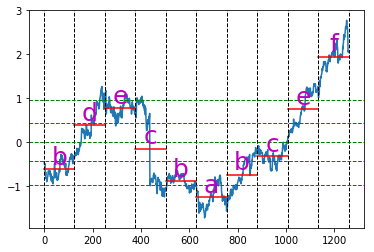

In [627]:
# Import package from pyts, a Python package for time series visualization 
from pyts.visualization import plot_paa_sax

plot_paa_sax(np.array(ts2.loc['A']), window_size=None, output_size=10, overlapping=True,
             n_bins=6, quantiles='gaussian')

To make the pre-clusters, an appropriate distance measure compatible with SAX is desirable. An extended MINDIST, so-called APXDIST has been proposed where the approximate distance between two time series is calculated using the indicators of each region. The indicator of a region is defined in such a way that the closeness of PAA coefficients (in the region) to the indicator is the highest in that region. For defining the indicator, the arithmetic mean of each area (minimum
and maximum) is defined as the indicator of the area as the best estimator of the regions. The indicators can be calculated using breakpoints.The breakpoints are a list of numbers B = b1 ...ba1 that determine the area of each symbol in SAX transformation. 

Below sections defined the indicators and create a dissimilarity matrix with size of 470x470 by calculating the distance between every company.

In [18]:
# Define the breakpoints array
breakpoints = [0.97, 0.43, 0, -0.43, -0.97]

# The max_paa variable holds the global maximum paa value of the time series while the min_paa variable holds the global 
# minimum paa value of the time series
max_paa = ts3.values.max(1).max()
min_paa = ts3.values.min(1).min()

# Create indicator for each region
ind = [round((max_paa+0.97)/2,2),0.70,0.21,-0.21,-0.7,round((min_paa-0.97)/2,2)]
ind

[1.75, 0.7, 0.21, -0.21, -0.7, -1.6000000000000001]

In [19]:
# create a lookup dictionary, sym_dic that store the distance between each symbol
sym_dic = {}
sym = ['a', 'b', 'c', 'd','e','f']

for i in range(6):
    for j in range(6):
        sym_dic[sym[i] + sym[j]] = abs(round(ind[i]-ind[j],2))

sym_dic

{'aa': 0.0,
 'ab': 1.05,
 'ac': 1.54,
 'ad': 1.96,
 'ae': 2.4500000000000002,
 'af': 3.3500000000000001,
 'ba': 1.05,
 'bb': 0.0,
 'bc': 0.49,
 'bd': 0.91,
 'be': 1.4,
 'bf': 2.2999999999999998,
 'ca': 1.54,
 'cb': 0.49,
 'cc': 0.0,
 'cd': 0.42,
 'ce': 0.91,
 'cf': 1.8100000000000001,
 'da': 1.96,
 'db': 0.91,
 'dc': 0.42,
 'dd': 0.0,
 'de': 0.49,
 'df': 1.3899999999999999,
 'ea': 2.4500000000000002,
 'eb': 1.4,
 'ec': 0.91,
 'ed': 0.49,
 'ee': 0.0,
 'ef': 0.90000000000000002,
 'fa': 3.3500000000000001,
 'fb': 2.2999999999999998,
 'fc': 1.8100000000000001,
 'fd': 1.3899999999999999,
 'fe': 0.90000000000000002,
 'ff': 0.0}

In [20]:
# Create an empty data frame to store dissimilarity matrix with size of 470x470
dist_matrix = pd.DataFrame(0, index=ts.index, columns=ts.index)
dist_matrix.shape

(470, 470)

In [23]:
# n denotes length of time series
# w denotes word size
n=1259
w=10

# Calculate the distance between the companies using APXDIST based on their symbols by looking up to the dictionary created
# earlier. 
for i in range(len(dist_matrix.index)):
    for j in range(len(dist_matrix.columns)):
        arr1 = np.array(ts_sax.loc[dist_matrix.index.values[i]])
        arr2 = np.array(ts_sax.loc[dist_matrix.columns.values[j]])
        
        ttl_dist = 0
        for k in range(10):
            ttl_dist = ttl_dist + (sym_dic[arr1[k]+arr2[k]]**2)
            
        dist_matrix.iloc[i,j] = round(np.sqrt(n/w)*np.sqrt(ttl_dist))

# Show the first five rows of the dissimilarity matrix, the values denote the distance/dissimilarity. 
# For example, the distance between AAL and A is 39.
dist_matrix.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Name,,,,,,,,,,,,,,,,,,,,,
A,0.0,39.0,65.0,42.0,31.0,58.0,40.0,43.0,38.0,34.0,...,46.0,27.0,36.0,55.0,56.0,27.0,41.0,43.0,23.0,46.0
AAL,39.0,0.0,43.0,18.0,18.0,28.0,14.0,26.0,25.0,26.0,...,21.0,30.0,55.0,38.0,55.0,28.0,31.0,20.0,33.0,31.0
AAP,65.0,43.0,0.0,46.0,47.0,28.0,45.0,46.0,49.0,50.0,...,36.0,54.0,60.0,49.0,47.0,51.0,42.0,38.0,57.0,50.0
AAPL,42.0,18.0,46.0,0.0,18.0,28.0,13.0,16.0,13.0,16.0,...,11.0,24.0,63.0,27.0,65.0,27.0,37.0,18.0,28.0,17.0
ABBV,31.0,18.0,47.0,18.0,0.0,33.0,16.0,23.0,20.0,15.0,...,22.0,20.0,52.0,32.0,55.0,18.0,31.0,23.0,23.0,23.0


To cluster the approximated data, kmodes package is used to perform clustering, dividing the N time series into k partitions. K-Modes is based on the kMeans family algorithm, and is used for clustering of categorical data, considering that time series represented by SAX is categorical data in each segment. The number of clusters is calculated by taking square root of total number of time series, 470 divided by 2, which produces a number of approximately 15 clusters.

In [307]:
from kmodes.kmodes import KModes

# Define the number of the cluster 
n_clusters = round(np.sqrt(470/2)).astype(int)

# Create a lookup dictionary that map letters to numbers. For example, symbol 'a' is mapped to number 1 and so on.
int_to_sym_dic = {}
sym = ['a', 'b', 'c', 'd','e','f']
for x in range(6):
    int_to_sym_dic[x] = sym[x]

# Define the dissimilarity function that takes in two time series(from ts_sax dataframe) as input and return distance as output.
def dissim_func(a,b,**_):
    ttl_dist = 0
    paa_size = 10
    sim = []

    for i in range(a.shape[0]):
        for k in range(a.shape[1]):
            ttl_dist = np.sum([ttl_dist,(sym_dic[int_to_sym_dic[a[i][k]]+int_to_sym_dic[b[k]]]**2)])
            
        s = round(np.sqrt(n/w)*np.sqrt(ttl_dist)).astype(int)
        sim = np.append(sim,[s])
        ttl_dist = 0
    
    return sim.astype(int)

# Apply kmodes function to define the parameters
km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1, cat_dissim = dissim_func)

# Fit and cluster the data
clusters = km.fit_predict(ts_sax)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 193, cost: 7475.0
Run 1, iteration: 2/100, moves: 86, cost: 7120.0
Run 1, iteration: 3/100, moves: 45, cost: 7110.0
Run 1, iteration: 4/100, moves: 16, cost: 7112.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 195, cost: 7282.0
Run 2, iteration: 2/100, moves: 75, cost: 7074.0
Run 2, iteration: 3/100, moves: 37, cost: 7005.0
Run 2, iteration: 4/100, moves: 17, cost: 7004.0
Run 2, iteration: 5/100, moves: 5, cost: 6985.0
Run 2, iteration: 6/100, moves: 4, cost: 7006.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 192, cost: 7200.0
Run 3, iteration: 2/100, moves: 70, cost: 7066.0
Run 3, iteration: 3/100, moves: 29, cost: 7174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 176, cost:

In [308]:
# Print the resulting clusters in array
print(clusters)

[11 14 10  3 14 12 14  8  8  5 14  9 10  1  3  3  6  8  5 10  9  3  5  1 10
  1  5 12  3 10  1  1 14  4 13 14  3  5 13  5  3  3  5  6  4  3  3  3  4  8
 12  8  5  8 11  7  7  1  1  6  1  1  8  6 13 14  3  9  3  3  5  4 12  1  5
  7 10 11  3 14  9  1  3  8  8 12 14  4  8  6 13  5 13  2  3  8  1  3  5 10
 11  8 13 11 14  6 14  3  6  3  7  5  3  1  8  4 13  2 10  6  1  3  3  1 14
 13  0  0 12  6  6 10  0  2 11 12  8  8  3  3 10  6  8  6  9  0  2  3  5 11
  6 11  0 10  4 10  3  5 11  3  2 11  5  8  7  6 11  8  5  6  9  6  3  8  8
  1  7  1  6  6 11  7  6  3  7 10 10  7  3 11  5  7  8  6 11  1 12  6 11  8
  9 10 12 12  6  8  6  3  8  6 12  8  6  4  7  5  7 11  1  8  6  5  8 14 12
  3  8 11 12  1 11  0  3  9  4  9 11 11  3  5  5  4  7  1 10  1 12  4 14  0
  6 10  4  6 11 10 12 13  8  5  3 13  3  1  3 13  9  6  3 14  4  5  0 10  3
  8  6  0  5 10  3 12 12 14  1  8  0  8  3  3 13  8 11  6 14  3  6  1  3  5
  1  5 14 10  6 13  8  3  0  5  7  4 13 10  8  6  6  1 11  3 11  5 12 11  7
  7  6  5  5

In [493]:
# Assign the cluster array to a new column 'cluster' in dataframe ts2
ts2['cluster'] = clusters

# Get a glimpse of the companies and their assigned clusters. For example, company A is assigned to cluster 11 and company AAL is
# assigned to cluster 14.
ts2['cluster'].head()

A       11
AAL     14
AAP     10
AAPL     3
ABBV    14
Name: cluster, dtype: uint8

### Result

The time series of all companies in the dataset were divided into 15 clusters. A total of 15 subplots were generated to illustrate the time series of 3 companies in each cluster. As seen in the plot below, the time series in the same cluster are similar in term of shape and the time series in the different cluster are not similar in shape. This shows that the proposed pre-clustering method is able to cluster and most importantly, categorize the data well. These clusters can be used as the representations of the entire dataset, in other words, the total of 470 companies can be reduced to only 15 without losing much information.

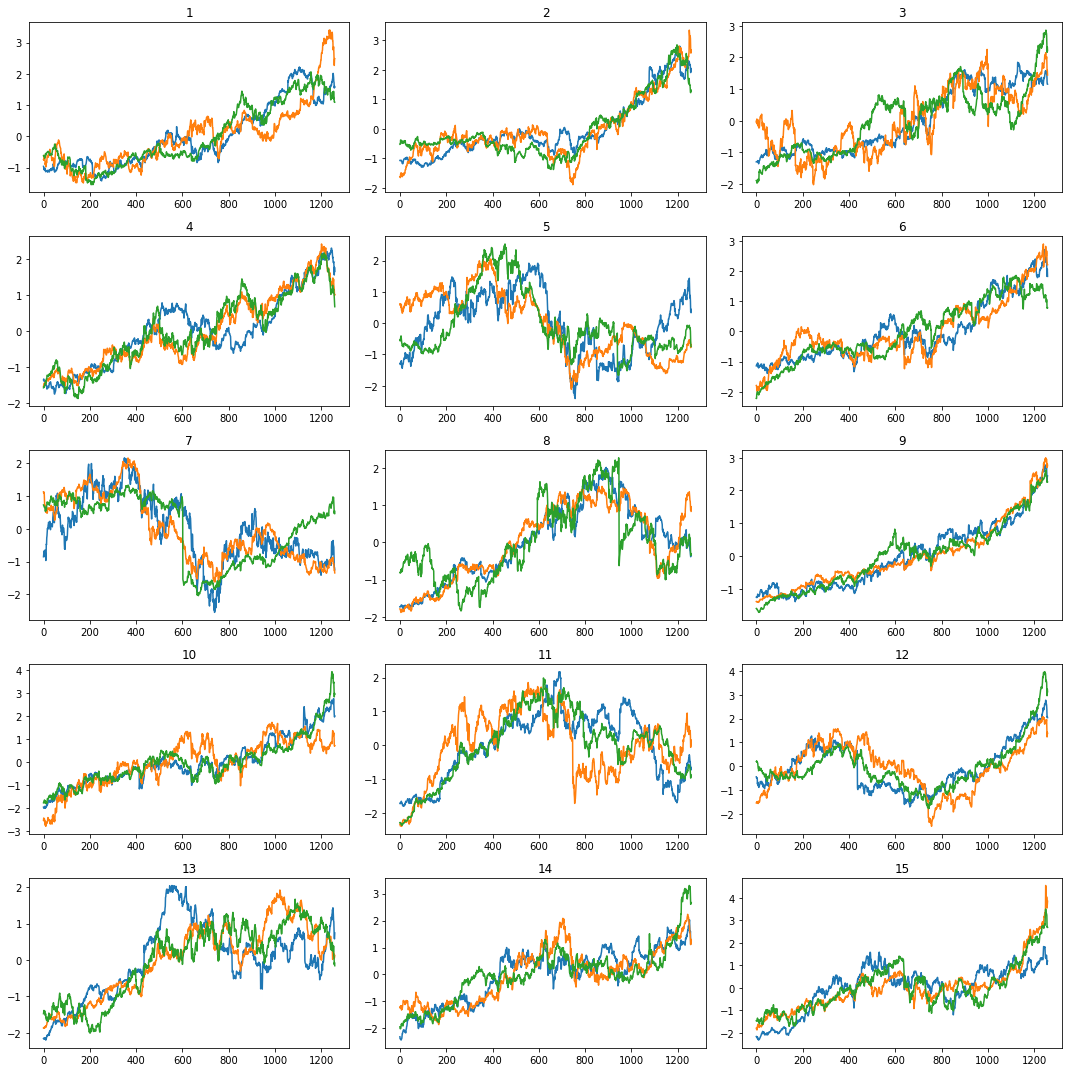

In [615]:
# Define the subplot size
fig, ax = plt.subplots(5,3, figsize=(15, 15))

# Create 15 subplots which correspond to 15 clusters where each subplot illustrates 3 time series within the same cluster.
a = 0
counter = 1
for b in np.arange(0,5):
    for c in np.arange(0,3):
        df0=ts2[ts2['cluster']==a][ts2.columns.difference(['cluster'])].transpose().iloc[:,:3]
        df0['len'] = list(range(len(df0)))

        ax[b][c].plot(df0['len'], df0.iloc[:,:3])
        ax[b][c].set_title(counter)
        a += 1
        counter += 1

fig.tight_layout()
plt.show()

Apart from time series plot, a pie chart was created to visualize the distribution of clusters. As shown in the pie chart below, the cluster with the largest size is cluster 3 where it takes up 12.8% while the cluster with the smallest size is cluster 2, with proportion of only 2.8%.

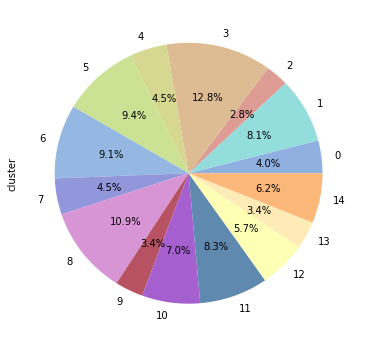

In [621]:
# Count each cluster size
clusters_counts = ts2['cluster'].value_counts().sort_index()

# Define the colors
colors = ['#91b0e2', '#94dddd', '#dd9c94', '#ddbc94','#d6d891','#cbe295','#95b8e2','#9296db',
          '#d895d6','#b75263','#a55fce','#6089af','#fdffb5','#ffebb5','#fcb879']

# Plot the pie chart that divides the clusters and show the percentage value of the proportions
clusters_counts.plot.pie(figsize=(6, 6),autopct='%.1f%%',colors = colors)

### References

[1] Aghabozorgi, S., & Teh, Y. (2014). Stock market co-movement assessment using a three-phase clustering method. Expert Systems With Applications, 41(4), 1301-1314. doi: 10.1016/j.eswa.2013.08.028<br>
[2] johannfaouzi/pyts. (2018). Retrieved from https://github.com/johannfaouzi/pyts<br>
[3] nicodv/kmodes. (2018). Retrieved from https://github.com/nicodv/kmodes <br>
[4] seninp/saxpy. (2018). Retrieved from https://github.com/seninp/saxpy<br>